<a href="https://colab.research.google.com/github/hritiksth764/END-COURSE-SESSION-4.0-/blob/main/Session_6_Dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget www.cs.cmu.edu/~ark/QA-data/data/Question_Answer_Dataset_v1.2.tar.gz 
#dataset loading directly from the url
!tar -xvf  Question_Answer_Dataset_v1.2.tar.gz


--2021-11-27 06:47:15--  http://www.cs.cmu.edu/~ark/QA-data/data/Question_Answer_Dataset_v1.2.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8254496 (7.9M) [application/x-gzip]
Saving to: ‘Question_Answer_Dataset_v1.2.tar.gz’

Question_Answer_Dat 100%[===================>]   7.87M   159KB/s    in 42s     

2021-11-27 06:47:57 (192 KB/s) - ‘Question_Answer_Dataset_v1.2.tar.gz’ saved [8254496/8254496]

Question_Answer_Dataset_v1.2/
Question_Answer_Dataset_v1.2/S08/
Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt
Question_Answer_Dataset_v1.2/S08/data/
Question_Answer_Dataset_v1.2/S08/data/set4/
Question_Answer_Dataset_v1.2/S08/data/set4/a6.txt.clean
Question_Answer_Dataset_v1.2/S08/data/set4/a3.txt.clean
Question_Answer_Dataset_v1.2/S08/data/set4/a3.txt
Question_Answer_Dataset_v1.2/S08/data/set4/a5.txt
Question_Answer_Dataset_v1.2/S

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
from torch import optim

import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import unicodedata
import numpy as np
import random
import re
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = 0
EOS_token = 1

In [ ]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
#class lang ends here below functions are not part of the lang class

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#Normalization
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readFile(input_name, output_name):
    pairs = []

    # Read the file and split into lines
    # done using static can be done dynamically  if user is made to enter the file path manually
    Directory = '/content/Question_Answer_Dataset_v1.2/'
    folder_names = ['S08/', 'S09/', 'S10/']
    file_name = 'question_answer_pairs.txt'
    
    for folder_name in folder_names:  #since there are more than one folder loop to iterate over each folder
      print("Reading ", folder_name)
      #concatenation for reading each folder
      lines = open(Directory + folder_name + file_name,encoding='utf-8',errors='ignore').read().strip().split('\n')

      # Split every line into pairs and normalize
      pairs.extend(
          [[normalizeString(s) for s in l.split('\t')[1:3]] for l in lines[1:]]  #control from here goes to normalizeString method
      )

    #objects of the class lang
    input_question = Lang(input_name) 
    output_answer = Lang(output_name)

    return input_question, output_answer, pairs

MAX_LENGTH = 10



def filterPair(p):
    return (len(p[0].split(' ')) < MAX_LENGTH and 
        len(p[1].split(' ')) < MAX_LENGTH)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(input_name, output_name):
    input_question, output_answer, pairs = readFile(input_name, output_name)
    print("\nRead %s sentence pairs" % len(pairs))
    
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_question.addSentence(pair[0])
        output_answer.addSentence(pair[1])
    
    print("Counted words:")
    print(input_question.name, input_question.n_words)
    print(output_answer.name, output_answer.n_words)
    return input_question, output_answer, pairs


input_question, output_answer, pairs = prepareData('ques', 'ans')
print("\n\nrandom.choice(pairs) = \n", random.choice(pairs))

Reading  S08/
Reading  S09/
Reading  S10/

Read 3998 sentence pairs
Trimmed to 2113 sentence pairs
Counting words...
Counted words:
ques 1993
ans 1367


random.choice(pairs) = 
 ['what bordered by saudi ?', 'qatar']


In [ ]:
#Default/mandatory encoder class

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]
#this will give index position of the word


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)  #appending the EOS token to the indices
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
#converting the str part into tensors

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_question, pair[0])
    target_tensor = tensorFromSentence(output_answer, pair[1])  #this is output tensor
    return (input_tensor, target_tensor)

teacher_forcing_ratio = 0.5  #what is teacher forcing ratio ?

#now the train function.
#max length is 10
def train(input_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, 
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(
        max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_question, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_answer.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

2m 56s (- 41m 17s) (5000 6%) 2.4162
5m 57s (- 38m 41s) (10000 13%) 1.8896
8m 56s (- 35m 45s) (15000 20%) 1.5003
11m 54s (- 32m 44s) (20000 26%) 1.1337
15m 0s (- 30m 0s) (25000 33%) 0.8556
18m 0s (- 27m 0s) (30000 40%) 0.6427
20m 59s (- 23m 59s) (35000 46%) 0.5108
24m 0s (- 21m 0s) (40000 53%) 0.4592
27m 4s (- 18m 3s) (45000 60%) 0.3785
30m 12s (- 15m 6s) (50000 66%) 0.3815
33m 18s (- 12m 6s) (55000 73%) 0.3601
36m 21s (- 9m 5s) (60000 80%) 0.3325
39m 23s (- 6m 3s) (65000 86%) 0.3411
42m 29s (- 3m 2s) (70000 93%) 0.3162
45m 34s (- 0m 0s) (75000 100%) 0.3138
> do the ants eat plants meats or both ?
= both
< both <EOS>

> does romania border hungary ?
= yes
< yes <EOS>

> have elephants been used as working animals ?
= yes
< yes <EOS>

> when do wolves molt ?
= late spring or early summer
< late spring or early summer <EOS>

> are gray wolves native to north america ?
= yes
< yes <EOS>

> is jakarta a city
= yes
< yes <EOS>

> is spanish language of the european union ?
= null
< null <EOS

<Figure size 432x288 with 0 Axes>

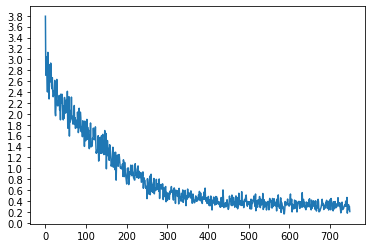

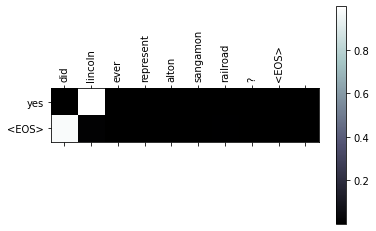

input = what is named after him ?
output = the celsius crater on the moon <EOS>


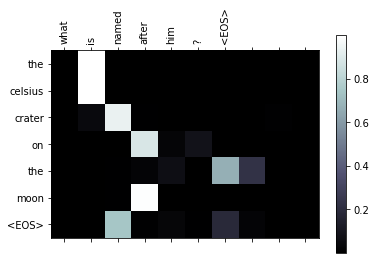

In [ ]:
hidden_size = 256

encoder1 = EncoderRNN(input_question.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(
    hidden_size, output_answer.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)



evaluateRandomly(encoder1, attn_decoder1)
evaluateAndShowAttention("did lincoln ever represent alton sangamon railroad ?")
evaluateAndShowAttention("what is named after him ?")